In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def compute_pagerank(link_matrix, damping_factor=0.8, max_iterations=100, tol=1.0e-6, custom_E=None):
    """
    Computes PageRank given a square matrix representing link structure, a damping factor, and an optional custom E.
    
    :param link_matrix: square numpy array where M[i, j] represents the link from 'j' to 'i', where j are columns (outgoing) and i are rows (incoming).
    :param damping_factor: probability at each page the "random surfer" will get bored and request another random page.
    :param max_iterations: maximum number of iterations to perform.
    :param tol: tolerance to check convergence (difference in pagerank vector norms).
    :param custom_E: Optional custom distribution vector for the teleportation step. If None, uses uniform distribution.
    :return: vector of PageRank scores.
    """
    n = link_matrix.shape[0]
    
    # Transform link matrix to probability matrix
    outlink_sums = np.sum(link_matrix, axis=0)
    prob_matrix = np.zeros_like(link_matrix)
    nonzero_outlinks = outlink_sums != 0
    prob_matrix[:, nonzero_outlinks] = link_matrix[:, nonzero_outlinks] / outlink_sums[nonzero_outlinks]
    
    # Handle dangling nodes
    dangling_nodes = np.where(outlink_sums == 0)[0]
    if dangling_nodes.size > 0:
        prob_matrix[:, dangling_nodes] = 1.0 / n
        
#     print('transition matrix: \n', prob_matrix)
#     print('\n')
    
    # Set up the custom or uniform E
    if custom_E is None:
        E = np.ones(n) / n
    else:
        E = np.array(custom_E)
        E = E / np.sum(E)  # Ensure E sums to 1
    
    # Initial PageRank values
    pagerank = np.ones(n) / n
    
    # PageRank iterative computation
    for _ in range(max_iterations):
        new_pagerank = damping_factor * np.dot(prob_matrix, pagerank) + (1 - damping_factor) * E
        
        # Check convergence
        if np.linalg.norm(new_pagerank - pagerank, ord=1) < tol:
            break
        
        pagerank = new_pagerank
    
    return pagerank

In [3]:
def visualize_graph(M):
    """
    Visualizes a directed graph defined by matrix M.
    
    Parameters:
    - M: numpy array, where M[i, j] is 1 if there is a link from node j to node i, else 0.
    """
    # Create a directed graph from M
    G = nx.DiGraph()
    
    # Add nodes and edges to the graph
    n = M.shape[0]
    for i in range(n):
        for j in range(n):
            if M[i, j] > 0:  # If there's a link from j to i
                G.add_edge(j, i)  # j -> i in networkx notation
    
    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, 
            edge_color='k', linewidths=1, font_size=15, 
            arrows=True, arrowsize=20)
    plt.show()

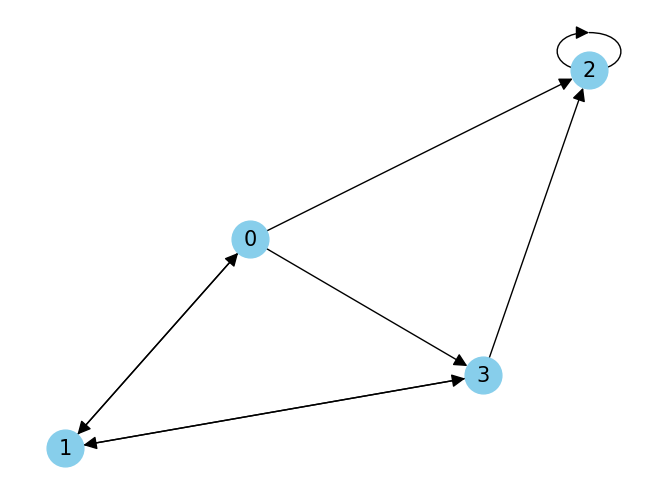

In [4]:
# Example link matrix (4 webpages)
M = np.array([[0, 1, 0, 0],
              [1, 0, 0, 1],
              [1, 0, 1, 1],
              [1, 1, 0, 0]], dtype=float)

visualize_graph(M)

In [5]:
pagerank_scores = compute_pagerank(M)
print("PageRank Scores:", pagerank_scores)

PageRank Scores: [0.10135159 0.12837872 0.64189097 0.12837872]


# Closed-form solutions

In [6]:
'''
R = cMR + (1-c)E
(I - cM)R = (1-c)E
R = (I - cM)^(-1) (1-c)(E)
'''
def closed_form_pagerank_1(M, d, E):
    n = M.shape[0]
    I = np.eye(n)  # Identity matrix
    R = np.linalg.inv(I - d * M) @ ((1 - d) * E)
    return R / np.sum(R)  # Ensure normalization

d = 0.8
n = M.shape[0]
E = np.ones(n) / n  # Uniform E

# Normalize columns of M
column_sums = M.sum(axis=0)
M[:, column_sums > 0] /= column_sums[column_sums > 0]

# Calculate and print PageRank
pagerank_1 = closed_form_pagerank_1(M, d, E)
print("Closed-Form Solution 1 PageRank:", pagerank_1)

Closed-Form Solution 1 PageRank: [0.10135135 0.12837838 0.64189189 0.12837838]


In [7]:
'''
R* = (M + b1^T)R*
where b=(1-d)E
'''
def closed_form_pagerank_2(M, d, E):
    n = M.shape[0]
    # Ensure E is a column vector for correct matrix multiplication
    E = E.reshape((n, 1))
    one_vector = np.ones((n, 1))
    
    # Constructing the adjusted matrix: dM + (1-d) * (E @ one_vector.T)
    adjusted_matrix = d * M + (1 - d) * (E @ one_vector.T)
    
    # Calculate the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(adjusted_matrix)
    
    # Find the principal eigenvector (eigenvector corresponding to the largest eigenvalue)
    principal_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
    
    # Normalize the principal eigenvector to ensure it represents a probability distribution
    R_star = np.real(principal_eigenvector / np.sum(principal_eigenvector))
    
    # Ensure R_star is a 1-dimensional array for consistency
    R_star = R_star.flatten()
    
    return R_star

# Calculate and print PageRank using the second closed-form solution
pagerank_2 = closed_form_pagerank_2(M, d, E.flatten())  # Ensure E is a 1-dimensional array when calling
print("Closed-Form Solution 2 PageRank:", pagerank_2)


Closed-Form Solution 2 PageRank: [0.10135135 0.12837838 0.64189189 0.12837838]


# Tune teleportation probability

Lowering d: Decreasing the damping factor increases the importance of the teleportation step, thereby reducing the relative impact of the link structure. This can make the PageRank more uniform across pages, potentially useful in graphs where many pages are highly interlinked without clear importance distinctions. </br>
Increasing d: Increasing the damping factor places more emphasis on the graph's link structure. This is useful when the structure of links is a strong indicator of a page's importance.

In [13]:
d_values = np.linspace(0,1,11)

for d in d_values:
    print(f'teleportation probability: {1-d:.1f}')
    pagerank_scores = compute_pagerank(M, damping_factor = d)
    print("PageRank Scores:", pagerank_scores)

teleportation probability: 1.0
PageRank Scores: [0.25 0.25 0.25 0.25]
teleportation probability: 0.9
PageRank Scores: [0.26193437 0.25059531 0.23749844 0.24997188]
teleportation probability: 0.8
PageRank Scores: [0.272953   0.2522745  0.22497925 0.24979325]
teleportation probability: 0.7
PageRank Scores: [0.2833319  0.25490374 0.21240408 0.24936028]
teleportation probability: 0.6
PageRank Scores: [0.2932961  0.2583799  0.19972076 0.24860324]
teleportation probability: 0.5
PageRank Scores: [0.30303009 0.26262641 0.18686876 0.24747474]
teleportation probability: 0.4
PageRank Scores: [0.312688   0.26758867 0.17378242 0.24594091]
teleportation probability: 0.3
PageRank Scores: [0.32239969 0.27323152 0.16039188 0.24397691]
teleportation probability: 0.2
PageRank Scores: [0.33227871 0.27953571 0.14662439 0.2415612 ]
teleportation probability: 0.1
PageRank Scores: [0.34242768 0.28649543 0.13240323 0.23867367]
teleportation probability: 0.0
PageRank Scores: [0.35294143 0.29411748 0.11764701 0.

# Tune matrix M

The web graph M represents the link structure of the web, where M[i,j] indicates a link from page j to page i. </br>
</br>
Tuning approach: </br>
- normalisation: Ensure the columns of M sum to 1 (or 0 for pages with no out-links, a.k.a. dangling nodes). This represents the probability of transitioning from one page to another. </br>
- Adjusting Link Weights: Instead of binary presence or absence of links, you can introduce weights to represent the strength or quality of links. This could be based on factors like the context of the link, the authority of the linking page, etc. </br> </br>


Possible tunings: </br>
- Graph Density: Sparse versus dense graphs.</br>
- Clustering: Highly connected subgraphs versus more uniform connectivity. </br>
- Dangling Nodes: Graphs with many versus few dangling nodes (nodes with no outbound links). </br>
- Graph Size: The effect of the number of nodes in the graph.
</br></br>

Common observations: </br>
1. Dense Graphs often distribute PageRank more evenly since there are more paths for the random surfer model to follow, reducing the likelihood of any single page becoming disproportionately influential.
2. Sparse Graphs with Clear Hierarchies tend to show more pronounced differences in PageRank scores, highlighting key nodes that act as hubs or authorities.
3. Dangling Nodes can skew PageRank by accumulating rank without distributing it, unless handled by teleportation (damping factor) or redistribution.
4. Graph Size and Scale: Larger graphs may require more iterations for PageRank to converge, and the absolute differences in PageRank scores may be smaller as rank is distributed across more nodes.

Pagerank for sparse graph: 
 [0.21206934 0.05151048 0.11744374 0.13030066 0.14546514 0.06524659
 0.05151048 0.10969649 0.06524659 0.05151048]


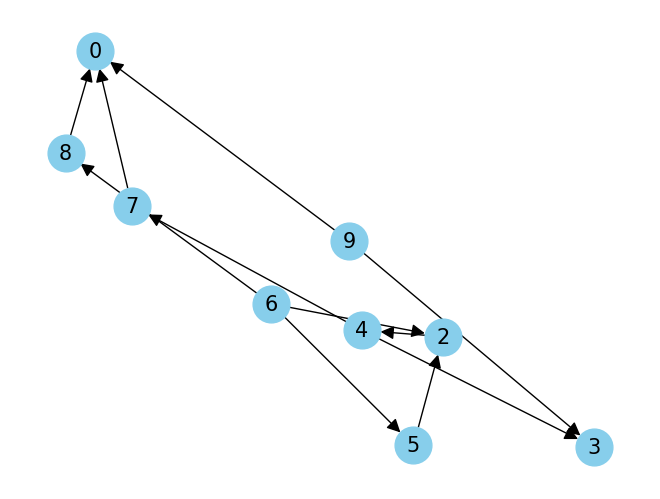

Pagerank for dense graph: 
 [0.12567588 0.08219865 0.09165346 0.10645275 0.04682732 0.09181311
 0.07971858 0.13753654 0.12250789 0.11561582]


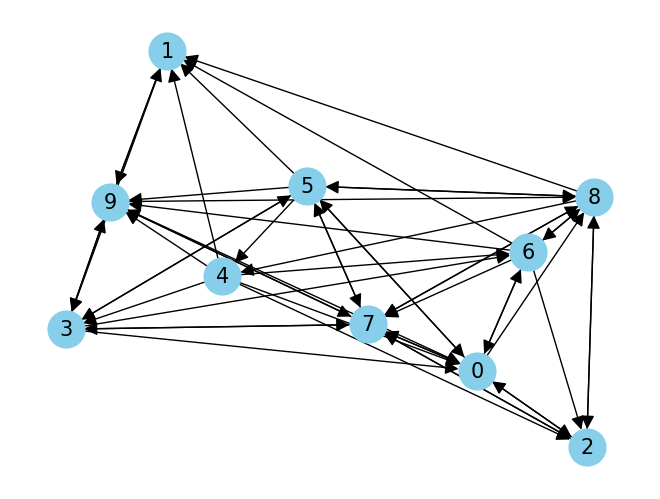

Pagerank for cycle graph: 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


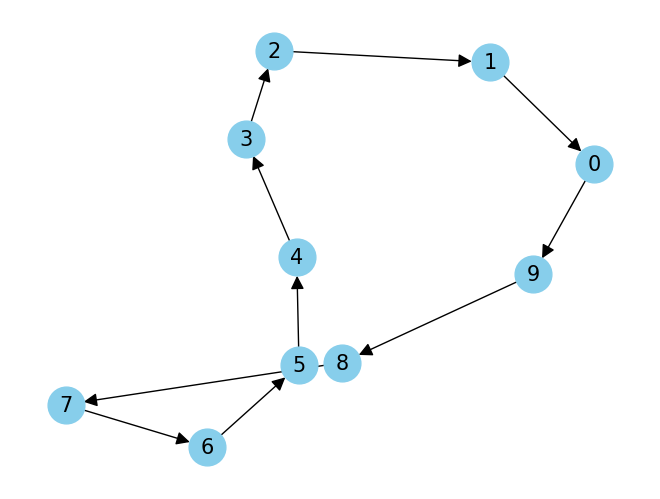

Pagerank for complete graph: 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


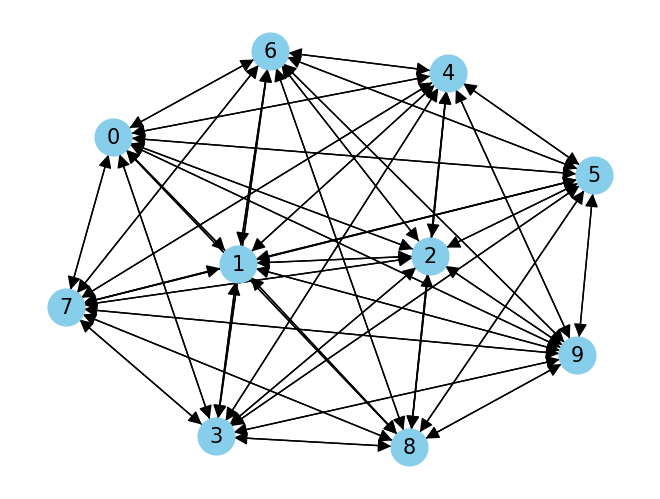

In [9]:
def generate_adjacency_matrix(type='sparse', n=10, extra_param=None):
    """
    Generates an adjacency matrix M for a graph of type 'type' with n nodes.
    
    Parameters:
    - type: Type of graph to generate ('sparse', 'dense', 'cycle', 'complete', or custom types).
    - n: Number of nodes in the graph.
    - extra_param: Additional parameter for graph generation, e.g., probability for random graphs.
    
    Returns:
    - An adjacency matrix representing the graph.
    """
    if type == 'sparse':
        G = nx.erdos_renyi_graph(n, p=0.1, directed=True)
    elif type == 'dense':
        G = nx.erdos_renyi_graph(n, p=0.5, directed=True)
    elif type == 'cycle':
        G = nx.cycle_graph(n, create_using=nx.DiGraph())
    elif type == 'complete':
        G = nx.complete_graph(n, create_using=nx.DiGraph())
    else:
        raise ValueError("Unsupported graph type.")
    
    # Convert to adjacency matrix
    M = nx.to_numpy_array(G)
    return M

# Example usage
types_of_graphs = ['sparse', 'dense', 'cycle', 'complete']
n = 10  # Number of nodes

for graph_type in types_of_graphs:
    M = generate_adjacency_matrix(type=graph_type, n=n)
    pagerank_scores = compute_pagerank(M)
    print(f"Pagerank for {graph_type} graph: \n", pagerank_scores)
    visualize_graph(M)

# Tune distribution vector E

In [10]:
M = np.array([[0, 1, 1, 0],
              [1, 0, 0, 1],
              [0, 0, 0, 1],
              [1, 0, 1, 0]], dtype=float)

# Custom E that emphasizes the first and last nodes more than others
custom_E = [0.4, 0.1, 0.1, 0.4]

pagerank_scores = compute_pagerank(M)
print("PageRank scores with default E:", pagerank_scores)

# Compute PageRank with custom E
pagerank_scores = compute_pagerank(M, custom_E=custom_E)
print("PageRank scores with custom E:", pagerank_scores)

PageRank scores with default E: [0.33227871 0.27953571 0.14662439 0.2415612 ]
PageRank scores with custom E: [0.34177187 0.26371325 0.12700424 0.26751064]
